# 🧪 Super Resolución Clásica - Técnicas en Python
Este notebook muestra implementaciones prácticas de cinco técnicas clásicas de super resolución: 
1. Interpolación (bilineal y bicúbica)
2. Multi-frame Super Resolution (MFSR)
3. Sparse Representation
4. Edge-Directed Interpolation
5. Neighbor Embedding


In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import img_as_float
from skimage.restoration import denoise_nl_means, estimate_sigma
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim

## Parameters

In [2]:
IMAGE_NAME = "low_z_offset.png"

## Degradation function

In [3]:
def degrade_image(hr_image, scale=0.5, seed=None):
    """
    Applies a combination of realistic degradations to an HR image to generate an LR image.
    If seed is provided, the process is reproducible.
    """
    
    if seed is not None:
        np.random.seed(seed)

    # 1. Random Gaussian blur
    if np.random.rand() < 0.7:
        ksize = np.random.choice([3, 5, 7])
        sigma = np.random.uniform(0.8, 2.0)
        hr_image = cv2.GaussianBlur(hr_image, (ksize, ksize), sigmaX=sigma)
    
    # 2. Random motion blur (optional)
    if np.random.rand() < 0.3:
        size = np.random.choice([5, 7, 9])
        kernel_motion_blur = np.zeros((size, size))
        kernel_motion_blur[int((size-1)/2), :] = np.ones(size)
        kernel_motion_blur = kernel_motion_blur / size
        hr_image = cv2.filter2D(hr_image, -1, kernel_motion_blur)
    
    # 3. Downsample with random interpolation
    interp_method = np.random.choice([
        cv2.INTER_LINEAR, cv2.INTER_CUBIC, cv2.INTER_AREA, cv2.INTER_LANCZOS4
    ])
    h, w = hr_image.shape[:2]
    lr_image = cv2.resize(hr_image, (int(w*scale), int(h*scale)), interpolation=interp_method)
    
    # 4. Add Gaussian noise
    if np.random.rand() < 0.7:
        noise_std = np.random.uniform(2, 10)
        noise = np.random.normal(0, noise_std, lr_image.shape).astype(np.float32)
        lr_image = np.clip(lr_image.astype(np.float32) + noise, 0, 255).astype(np.uint8)
    
    # 5. JPEG compression artifacts
    if np.random.rand() < 0.7:
        encode_param = [int(cv2.IMWRITE_JPEG_QUALITY), np.random.randint(20, 60)]
        _, encimg = cv2.imencode('.jpeg', lr_image, encode_param)
        lr_image = cv2.imdecode(encimg, 1)
    
    return lr_image

## 1. Interpolación bilineal, bicúbica, por area y lanczos

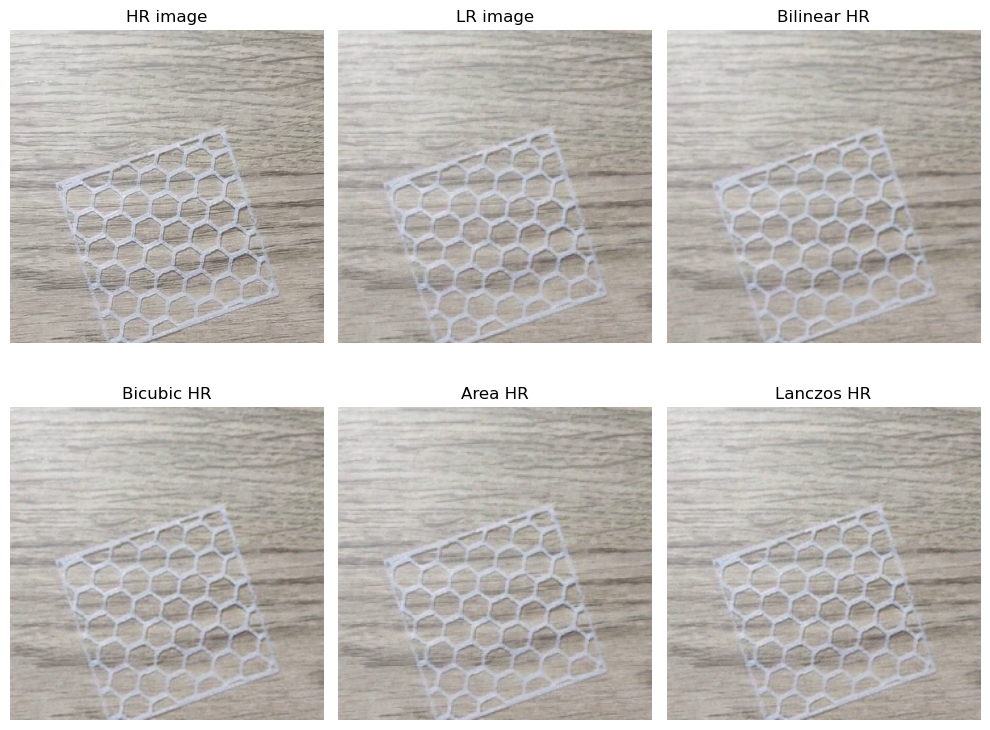

In [4]:
hr_image = cv2.imread(IMAGE_NAME)
hr_image = cv2.cvtColor(hr_image, cv2.COLOR_BGR2RGB)

lr_image = degrade_image(hr_image, scale=0.5, seed=42)

bilinear = cv2.resize(lr_image, (hr_image.shape[1], hr_image.shape[0]), interpolation=cv2.INTER_LINEAR)
bicubic = cv2.resize(lr_image, (hr_image.shape[1], hr_image.shape[0]), interpolation=cv2.INTER_CUBIC)
area = cv2.resize(lr_image, (hr_image.shape[1], hr_image.shape[0]), interpolation=cv2.INTER_AREA)
lanczos = cv2.resize(lr_image, (hr_image.shape[1], hr_image.shape[0]), interpolation=cv2.INTER_LANCZOS4)

plt.figure(figsize=(10, 8))
plt.subplot(2, 3, 1); plt.title("HR image"); plt.imshow(hr_image); plt.axis('off')
plt.subplot(2, 3, 2); plt.title("LR image"); plt.imshow(lr_image); plt.axis('off')
plt.subplot(2, 3, 3); plt.title("Bilinear HR"); plt.imshow(bilinear); plt.axis('off')
plt.subplot(2, 3, 4); plt.title("Bicubic HR"); plt.imshow(bicubic); plt.axis('off')
plt.subplot(2, 3, 5); plt.title("Area HR"); plt.imshow(area); plt.axis('off')
plt.subplot(2, 3, 6); plt.title("Lanczos HR"); plt.imshow(lanczos); plt.axis('off')
plt.tight_layout()
plt.show()

#### Evaluation

In [5]:
psnr_bilinear = psnr(hr_image, bilinear)
psnr_bicubic = psnr(hr_image, bicubic)
psnr_area = psnr(hr_image, area)
psnr_lanczos = psnr(hr_image, lanczos)
print(f"PSNR Bilinear: {psnr_bilinear:.2f} dB")
print(f"PSNR Bicubic: {psnr_bicubic:.2f} dB")
print(f"PSNR Area: {psnr_area:.2f} dB")
print(f"PSNR Lanczos: {psnr_lanczos:.2f} dB")

(ssim_bilinear, diff_bilinear) = ssim(hr_image, bilinear, channel_axis=2, full=True)
(ssim_bicubic, diff_bicubic) = ssim(hr_image, bicubic, channel_axis=2, full=True)
(ssim_area, diff_area) = ssim(hr_image, area, channel_axis=2, full=True)
(ssim_lanczos, diff_lanczos) = ssim(hr_image, lanczos, channel_axis=2, full=True)
print(f"\nSSIM Bilinear: {ssim_bilinear:.4f}")
print(f"SSIM Bicubic: {ssim_bicubic:.4f}")
print(f"SSIM Area: {ssim_area:.4f}")
print(f"SSIM Lanczos: {ssim_lanczos:.4f}")

mse_bilinear = np.mean((hr_image - bilinear) ** 2)
mse_bicubic = np.mean((hr_image - bicubic) ** 2)
mse_area = np.mean((hr_image - area) ** 2)
mse_lanczos = np.mean((hr_image - lanczos) ** 2)
print(f"\nMSE Bilinear: {mse_bilinear:.2f}")
print(f"MSE Bicubic: {mse_bicubic:.2f}")
print(f"MSE Area: {mse_area:.2f}")
print(f"MSE Lanczos: {mse_lanczos:.2f}")

PSNR Bilinear: 28.35 dB
PSNR Bicubic: 29.00 dB
PSNR Area: 28.33 dB
PSNR Lanczos: 29.11 dB

SSIM Bilinear: 0.7387
SSIM Bicubic: 0.7759
SSIM Area: 0.7476
SSIM Lanczos: 0.7809

MSE Bilinear: 47.59
MSE Bicubic: 45.18
MSE Area: 48.78
MSE Lanczos: 44.91


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.06180049564789432..0.9908314275423484].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0715040376597627..0.9772156715850634].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.041278252024192774..0.9920710253332654].


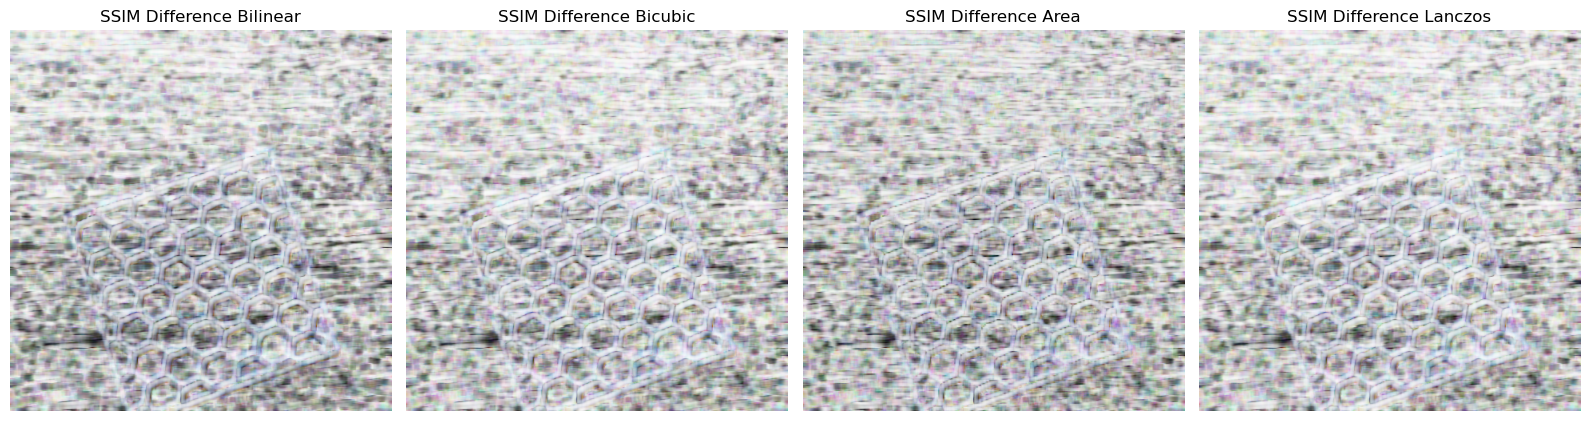

In [6]:
plt.figure(figsize=(16, 16))

# Plotting SSIM differences
plt.subplot(1, 4, 1)
plt.title("SSIM Difference Bilinear")
plt.imshow(diff_bilinear, cmap='gray')
plt.axis('off')

plt.subplot(1, 4, 2)
plt.title("SSIM Difference Bicubic")
plt.imshow(diff_bicubic, cmap='gray')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.title("SSIM Difference Area")
plt.imshow(diff_area, cmap='gray')
plt.axis('off')

plt.subplot(1, 4, 4)
plt.title("SSIM Difference Lanczos")
plt.imshow(diff_lanczos, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()

## 2. Iterative Back-Projection (IBP)

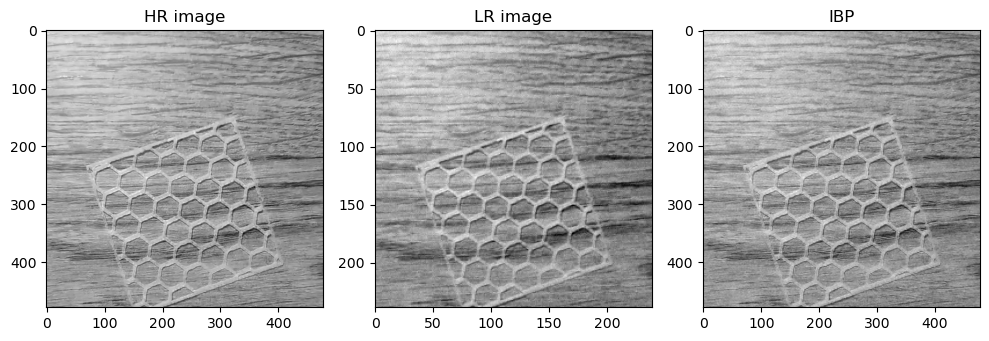

In [7]:
def back_projection(hr_image, lr_image, iterations=10):
    for _ in range(iterations):
        down = cv2.resize(hr_image, (lr_image.shape[1], lr_image.shape[0]), interpolation=cv2.INTER_LINEAR)
        diff = lr_image - down
        diff_up = cv2.resize(diff, (hr_image.shape[1], hr_image.shape[0]), interpolation=cv2.INTER_LINEAR)
        hr_image += diff_up
    
    return hr_image

hr_image = cv2.imread(IMAGE_NAME, cv2.IMREAD_GRAYSCALE)
lr_image = degrade_image(hr_image, scale=0.5, seed=42)

ibp = back_projection(hr_image.astype(np.float32), lr_image.astype(np.float32), iterations=10)

plt.figure(figsize=(10,4))
plt.subplot(1, 3, 1); plt.title("HR image"); plt.imshow(hr_image, cmap='gray')
plt.subplot(1, 3, 2); plt.title("LR image"); plt.imshow(lr_image, cmap='gray')
plt.subplot(1, 3, 3); plt.title("IBP"); plt.imshow(ibp, cmap='gray')
plt.tight_layout()
plt.show()

#### Evaluation

In [8]:
# calculate psnr and ssim for the back-projected image
data_range = np.max(hr_image) - np.min(hr_image)

psnr_hr = psnr(hr_image, ibp, data_range=data_range)
(ssim_hr_score, diff) = ssim(hr_image, ibp, data_range=data_range, channel_axis=None, full=True)

print(f"\nPSNR HR: {psnr_hr:.2f} dB")
print(f"SSIM HR: {ssim_hr_score:.4f}")


PSNR HR: 30.97 dB
SSIM HR: 0.9099


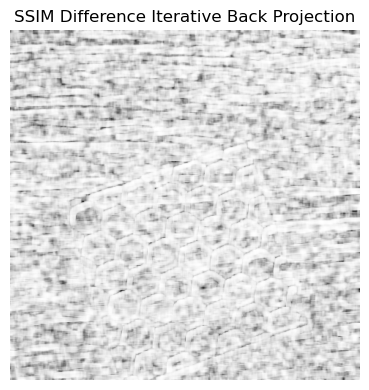

In [9]:
plt.figure(figsize=(8, 4))
plt.title("SSIM Difference Iterative Back Projection")
plt.imshow(diff, cmap='gray')
plt.axis('off')
plt.tight_layout()
plt.show()

## 3. Non-Local Means Super-Resolution

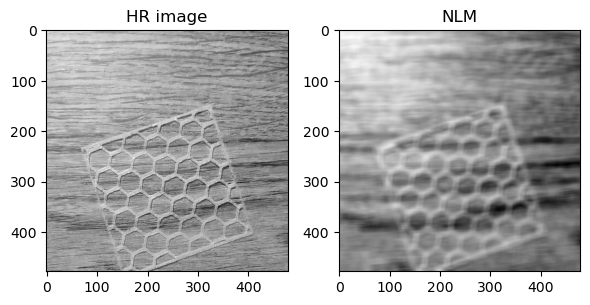

In [10]:
hr_image = cv2.imread(IMAGE_NAME, cv2.IMREAD_GRAYSCALE)

sigma_est = np.mean(estimate_sigma(hr_image))

nlm = denoise_nl_means(img_as_float(hr_image), h=1.15 * sigma_est, patch_size=5, patch_distance=6, fast_mode=True)

plt.figure(figsize=(6,4))
plt.subplot(1, 2, 1); plt.title("HR image"); plt.imshow(hr_image, cmap='gray')
plt.subplot(1, 2, 2); plt.title("NLM"); plt.imshow(nlm, cmap='gray')
plt.tight_layout()
plt.show()

#### Evaluation

PSNR NLM: 0.57 dB
SSIM NLM: 0.0018


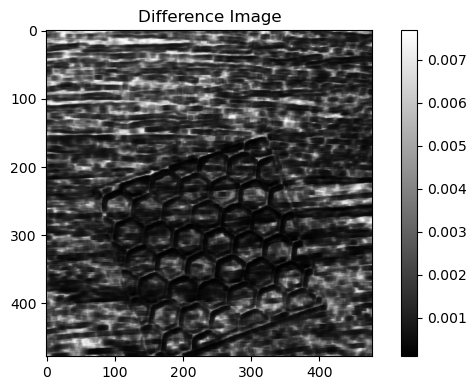

In [11]:
data_range = hr_image.max() - hr_image.min()

psnr_nlm = psnr(hr_image, nlm, data_range=data_range)
print(f"PSNR NLM: {psnr_nlm:.2f} dB")

(ssim_value, diff) = ssim(hr_image, nlm, full=True, data_range=data_range)
print(f"SSIM NLM: {ssim_value:.4f}")

plt.figure(figsize=(6, 4))
plt.title("Difference Image")
plt.imshow(diff, cmap='gray')
plt.colorbar()
plt.tight_layout()
plt.show()

## 4. Edge-Guided Interpolation (EGI)

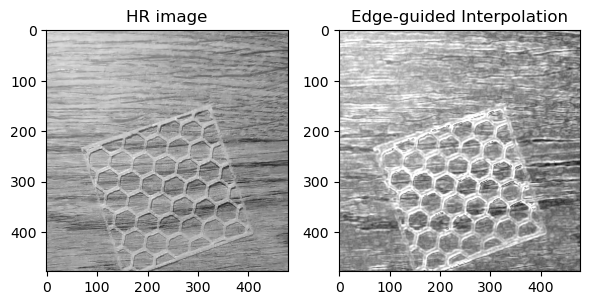

In [12]:
def edge_guided_interpolation(ground_truth, image):
    grad_x = cv2.Sobel(image, cv2.CV_64F, 1, 0)
    grad_y = cv2.Sobel(image, cv2.CV_64F, 0, 1)
    edges = np.hypot(grad_x, grad_y)

    upscaled = cv2.resize(image, (ground_truth.shape[1], ground_truth.shape[0]), interpolation=cv2.INTER_LINEAR)
    up_edges = cv2.resize(edges, (upscaled.shape[1], upscaled.shape[0]))

    sharpened = cv2.addWeighted(upscaled, 1.0, up_edges.astype(np.uint8), 0.5, 0)
    
    return sharpened

hr_image = cv2.imread(IMAGE_NAME, cv2.IMREAD_GRAYSCALE)
lr_image = degrade_image(hr_image, scale=0.5, seed=42)

egi_image = edge_guided_interpolation(hr_image, lr_image)

# Display the original and edge-guided interpolated images
plt.figure(figsize=(6, 4))
plt.subplot(1, 2, 1); plt.title("HR image"); plt.imshow(hr_image, cmap='gray')
plt.subplot(1, 2, 2); plt.title("Edge-guided Interpolation"); plt.imshow(egi_image, cmap='gray')
plt.tight_layout()
plt.show()

#### Evaluation

PSNR Edge-guided Interpolation: 14.55 dB
SSIM Edge-guided Interpolation: 0.4324


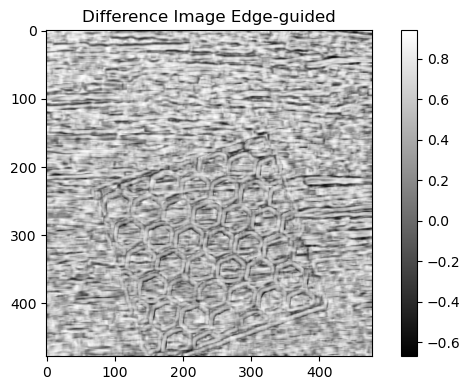

In [13]:
data_range = hr_image.max() - hr_image.min()

psnr_edge_guided = psnr(hr_image, egi_image, data_range=data_range)
print(f"PSNR Edge-guided Interpolation: {psnr_edge_guided:.2f} dB")

(ssim_edge_guided, diff_edge_guided) = ssim(hr_image, egi_image, full=True, data_range=data_range)
print(f"SSIM Edge-guided Interpolation: {ssim_edge_guided:.4f}")

plt.figure(figsize=(6, 4))
plt.title("Difference Image Edge-guided")
plt.imshow(diff_edge_guided, cmap='gray')
plt.colorbar()
plt.tight_layout()
plt.show()

## 5. Frequency Domain Extrapolation

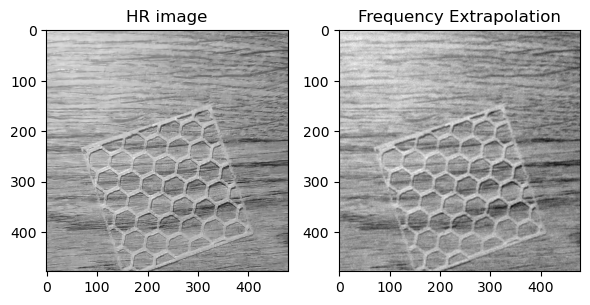

In [14]:
def frequency_extrapolation(ground_truth, image):
    f = np.fft.fft2(image)
    fshift = np.fft.fftshift(f)
    
    # Zero-padding in frequency domain (increasing resolution)
    rows, cols = image.shape
    pad_rows = ground_truth.shape[0]
    pad_cols = ground_truth.shape[1]
    f_padded = np.zeros((pad_rows, pad_cols), dtype=complex)
    center_row = pad_rows // 2
    center_col = pad_cols // 2
    half_rows = rows // 2
    half_cols = cols // 2

    # Compute start and end indices for both axes
    row_start = center_row - half_rows
    row_end = row_start + rows
    col_start = center_col - half_cols
    col_end = col_start + cols

    f_padded[row_start:row_end, col_start:col_end] = fshift

    # Inverse FFT
    f_ishift = np.fft.ifftshift(f_padded)
    img_upscaled = np.fft.ifft2(f_ishift)
    
    return np.abs(img_upscaled)

hr_image = cv2.imread(IMAGE_NAME, cv2.IMREAD_GRAYSCALE)
lr_image =  degrade_image(hr_image, scale=0.5, seed=42)

freq_up = frequency_extrapolation(hr_image, lr_image)

plt.figure(figsize=(6, 4))
plt.subplot(1, 2, 1); plt.title("HR image"); plt.imshow(hr_image, cmap='gray')
plt.subplot(1, 2, 2); plt.title("Frequency Extrapolation"); plt.imshow(freq_up, cmap='gray')
plt.tight_layout()
plt.show()

#### Evaluation

PSNR Frequency Extrapolation: 3.02 dB
SSIM Frequency Extrapolation: 0.1939


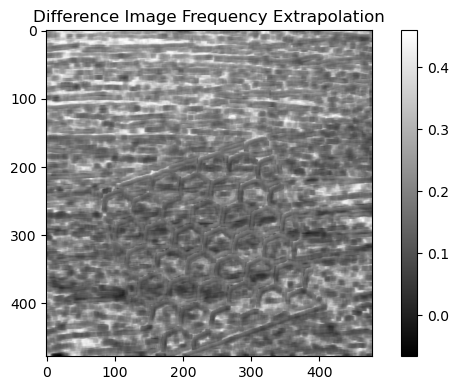

In [15]:
data_range = hr_image.max() - hr_image.min()

psnr_freq_extrapolation = psnr(hr_image, freq_up, data_range=data_range)
print(f"PSNR Frequency Extrapolation: {psnr_freq_extrapolation:.2f} dB")

(ssim_freq_extrapolation, diff_freq_extrapolation) = ssim(hr_image, freq_up, full=True, data_range=data_range)
print(f"SSIM Frequency Extrapolation: {ssim_freq_extrapolation:.4f}")

plt.figure(figsize=(6, 4))
plt.title("Difference Image Frequency Extrapolation")
plt.imshow(diff_freq_extrapolation, cmap='gray')
plt.colorbar()
plt.tight_layout()
plt.show()